<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Kaggle_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data from kaggle

1. Go to “Account”, go down the page, and find the “API” section.Click the “Create New API Token” button.The “kaggle.json” file will be downloaded.

2 . Upload it in the current directory


In [5]:
# 3.Install Kaggle API.
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# 4.Run the following code to configure the path to “kaggle.json”
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [7]:
# 5.In kaggle website, Click the “Data” section and copy the following line of link
# and Paste the code in the Colab notebook and run wit "!"

!kaggle competitions download -c dogs-vs-cats


 98% 796M/812M [00:04<00:00, 207MB/s]
100% 812M/812M [00:04<00:00, 208MB/s]


In [8]:
import zipfile
with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [9]:
import zipfile
with zipfile.ZipFile('/content/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [10]:
import zipfile
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [59]:
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage import io  # to read an image
import torch.nn as nn
from torchvision import transforms
import copy

In [39]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# how to classify train data

filenames = os.listdir('/content/train')
print(filenames[0])
print(filenames[0].split('.'))
print(filenames[0].split('.')[0])

cat.11699.jpg
['cat', '11699', 'jpg']
cat


In [41]:
class ClassifyData(Dataset):

  def __init__(self,root_dir,mode=None,transform=None):
    self.root_dir = root_dir
    self.file_list = os.listdir(root_dir)
    self.mode = mode
    self.transform = transform

  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self,index):
    image_name = self.file_list[index]
    image_path = os.path.join(self.root_dir,image_name) 
    image =  torchvision.io.read_image(image_path) 
    # ATTENTION : It is interesting to note that the shape of the image (with torchvision.io.read_image ) is
    # [3, H, W] whereas in most image formats on Python (with skimage.io.imread, Instead of creating a tensor, imageio creates an array.)
    # we would have had a shape [H, W, 3]
    if self.transform:
      image = self.transform(image)

    #getting lables
    if self.mode == 'train':
      if self.file_list[index].split('.')[0] == 'cat' :
        y_label = torch.tensor(0)
      else :
        y_label = torch.tensor(1)

      return (image,y_label)

    # training data is without label
    else : 
      return image
    


In [75]:
transform = transforms.Compose([transforms.ColorJitter(),
                                transforms.RandomRotation((-30,30)),
                                transforms.Resize([224,224])])

In [76]:
# Hyperparameters
num_classes = 2
learning_rate = 1e-3
batch_size = 8
num_epochs = 4

In [77]:
train_dataset = ClassifyData('/content/train',mode='train',transform = transform)
test_dataset = ClassifyData('/content/train',transform = transform)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)


# Example

In [78]:
a,b = next(iter(train_dataset))
print(a.type(),a.shape,b)

torch.ByteTensor torch.Size([3, 224, 224]) tensor(0)


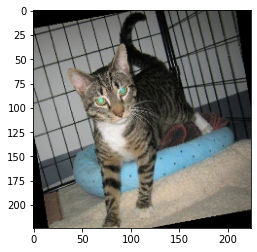

In [79]:
plt.imshow(a.permute((1,2,0))); # because our image is based on pytorch [3, H, W]

# Load data

In [80]:
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)

In [81]:
model.fc 

Linear(in_features=1024, out_features=1000, bias=True)

In [82]:
for parameter in model.parameters():
  parameter.requires_grad = False

input_size = model.fc.in_features
model.fc =nn.Linear(input_size,2)
print(model.fc)

model = model.to(device)

Linear(in_features=1024, out_features=2, bias=True)


In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(),learning_rate)

In [ ]:
best_acc = 0

for epoch in range(num_epochs):
  model.train()
  for i,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 ==0:
      print(f'Epoch {epoch+1}/{num_epochs} , step: {i+1}/{len(train_loader)} , loss = {loss.item() :.4f}')

  model.eval()
  n_correct = 0
  with torch.no_grad():
    for i,(images,labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      _,prediction = torch.max(outputs,1)
      n_correct += torch.sum(prediction==labels)

    acc_epoch = float(n_correct) / len(train_dataset)
    print(f'accuracy of epoch {epoch+1} = {acc_epoch}')

    if acc_epoch > best_acc:
      best_acc = acc_epoch
      best_model_wts = copy.deepcopy(model.state_dict())

    

Epoch 1/4 , step: 100/3125 , loss = 0.5099
Epoch 1/4 , step: 200/3125 , loss = 0.1013
Epoch 1/4 , step: 300/3125 , loss = 0.0516
Epoch 1/4 , step: 400/3125 , loss = 0.0532
Epoch 1/4 , step: 500/3125 , loss = 0.1490
Epoch 1/4 , step: 600/3125 , loss = 0.1691
Epoch 1/4 , step: 700/3125 , loss = 0.8225
Epoch 1/4 , step: 800/3125 , loss = 0.5943
Epoch 1/4 , step: 900/3125 , loss = 0.2235
Epoch 1/4 , step: 1000/3125 , loss = 0.1096
Epoch 1/4 , step: 1100/3125 , loss = 0.2407
Epoch 1/4 , step: 1200/3125 , loss = 0.1925
Epoch 1/4 , step: 1300/3125 , loss = 1.0530
Epoch 1/4 , step: 1400/3125 , loss = 0.6877
Epoch 1/4 , step: 1500/3125 , loss = 0.0394
Epoch 1/4 , step: 1600/3125 , loss = 0.0208
Epoch 1/4 , step: 1700/3125 , loss = 0.2008
Epoch 1/4 , step: 1800/3125 , loss = 0.0524
Epoch 1/4 , step: 1900/3125 , loss = 0.0223
Epoch 1/4 , step: 2000/3125 , loss = 1.8303
Epoch 1/4 , step: 2100/3125 , loss = 0.0159
Epoch 1/4 , step: 2200/3125 , loss = 0.8598
Epoch 1/4 , step: 2300/3125 , loss = 0.31